In [1]:
%tensorflow_version 2.x
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Progbar


TensorFlow 2.x selected.


In [0]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [3]:
height = 10
width = 10
n_channel = 3

x_train = np.zeros((100000,height,width, n_channel))+ 0.4*np.random.randn(100000,height,width, n_channel)
x_train[:50000,:5,:,0] = 1.
x_train[:50000,5:,:,0] = 0.5
x_train[:50000,5:,:,1] = 0.5
x_train[50000:,:,:5,1] = 1.
x_train[50000:,:,5:,2] = 1.

x_train = np.clip(x_train, 0, 1)

x_test = np.zeros((1000,height,width, n_channel))+ 0.4*np.random.randn(1000,height,width, n_channel)
x_test[:500,:5,:,0] = 1.
x_test[:500,5:,:,0] = 0.5
x_test[:500,5:,:,1] = 0.5
x_test[500:,:,:5,1] = 1.
x_test[500:,:,5:,2] = 1.

x_test = np.clip(x_test, 0, 1)

x_train.shape

(100000, 10, 10, 3)

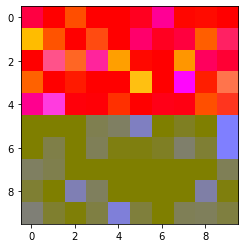

In [4]:
plt.imshow(x_train[0])

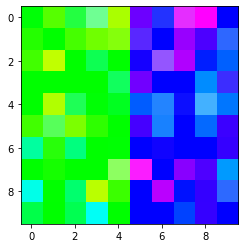

In [5]:
plt.imshow(x_train[50000])

In [0]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')



In [0]:
# Quantise the input data in q levels
q_levels = 64
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

In [0]:
# Creating input stream using tf.data API
batch_size = 256
train_buf = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)


In [0]:
class MaskedConv2D(tf.keras.layers.Layer):
    """Convolutional layers with masks for autoregressive models

    Convolutional layers with simple implementation to have masks type A and B.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 input_n_channels=3):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.input_n_channels = input_n_channels

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight("bias",
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        center = self.kernel_size // 2

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        mask[center, center + 1:, :, :] = 0.
        mask[center + 1:, :, :, :] = 0.

        for i in range(self.input_n_channels):
            for j in range(self.input_n_channels):
                if (self.mask_type == 'A' and i >= j) or (self.mask_type == 'B' and i > j):
                    mask[center, center, i::self.input_n_channels, j::self.input_n_channels] = 0.

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = tf.nn.conv2d(input, masked_kernel, strides=[1, self.strides, self.strides, 1], padding=self.padding)
        x = tf.nn.bias_add(x, self.bias)
        return x



In [0]:
class ResidualBlock(tf.keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel
     recurrent neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = keras.layers.Conv2D(filters=h, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h, kernel_size=3, strides=1)
        self.conv2c = keras.layers.Conv2D(filters=2 * h, kernel_size=1, strides=1)

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv2a(x)

        x = tf.nn.relu(x)
        x = self.conv2b(x)

        x = tf.nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

In [0]:
# Create PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(3):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
# Prepare optimizer and loss function
lr_decay = 0.9999
learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [0]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

In [14]:
# --------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 50
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    progbar = Progbar(n_iter)
    print('Epoch {:}/{:}'.format(epoch + 1, n_epochs))

    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)

        progbar.add(1, values=[("loss", loss)])

Epoch 1/150
391/391 [==============================] - 13s 34ms/step - loss: 1.2577
Epoch 2/150
391/391 [==============================] - 10s 25ms/step - loss: 1.0070
Epoch 3/150
391/391 [==============================] - 10s 25ms/step - loss: 0.9502
Epoch 4/150
391/391 [==============================] - 10s 25ms/step - loss: 0.9019
Epoch 5/150
391/391 [==============================] - 10s 25ms/step - loss: 0.8811
Epoch 6/150
391/391 [==============================] - 10s 25ms/step - loss: 0.8463
Epoch 7/150
391/391 [==============================] - 10s 25ms/step - loss: 0.8344
Epoch 8/150
391/391 [==============================] - 10s 25ms/step - loss: 0.8372
Epoch 9/150
391/391 [==============================] - 10s 25ms/step - loss: 0.8428
Epoch 10/150
391/391 [==============================] - 10s 25ms/step - loss: 0.7926
Epoch 11/150
391/391 [==============================] - 10s 25ms/step - loss: 0.7974
Epoch 12/150
391/391 [==============================] - 10s 26ms/step - lo

KeyboardInterrupt: ignored

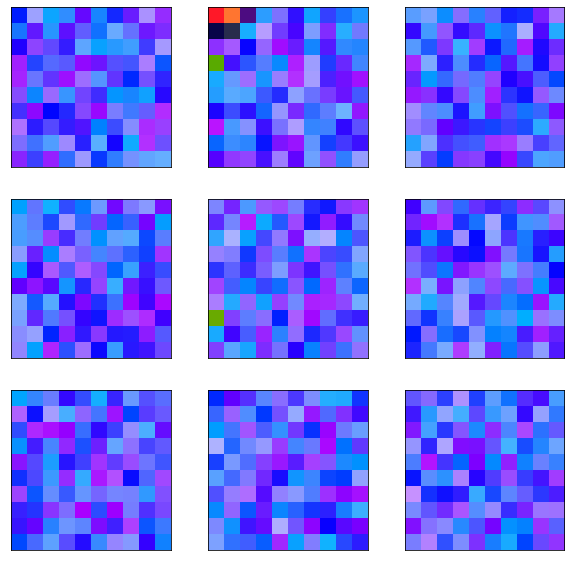

In [27]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
samples = np.zeros((10, height,width,n_channel)) + 0.7*np.random.rand(10,height,width, n_channel)
samples = np.clip(samples, 0, 1)


for i in range(height):
    for j in range(width):
        for k in range(n_channel):
            logits = pixelcnn(samples)
            logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
            logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
            next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
            samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]
            

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(samples[i, :, :, :])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

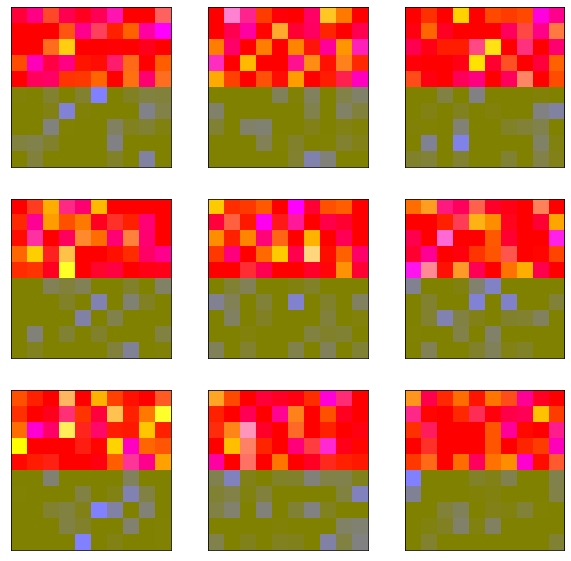

In [20]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
occlude_start_row = 14
num_generated_images = 1
samples = np.copy(x_test_quantised[:10, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, height):
    for j in range(width):
        for k in range(n_channel):
            logits = pixelcnn(samples)
            logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
            logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
            next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
            samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]
            

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(samples[i, :, :, :])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

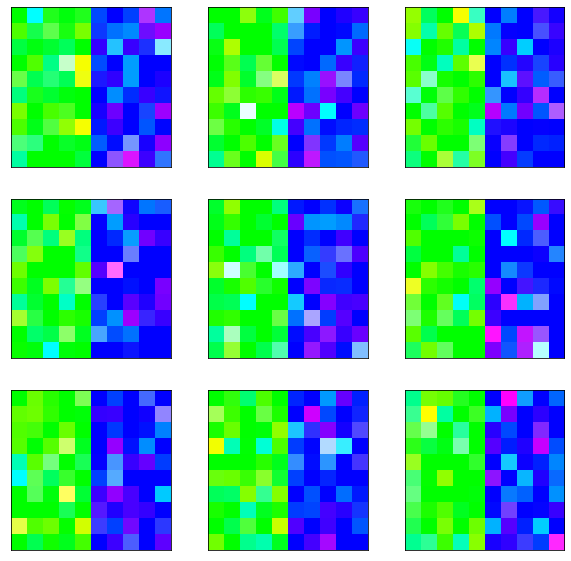

In [23]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
occlude_start_row = 14
num_generated_images = 1
samples = np.copy(x_test_quantised[500:510, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, height):
    for j in range(width):
        for k in range(n_channel):
            logits = pixelcnn(samples)
            logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
            logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
            next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
            samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]
            

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(samples[i, :, :, :])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()